# Brain Tumor Detection using VGG-16 Convolutional Neural Network (CNN) with Transfer Learning
maram abdallah

# T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
## T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
## T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
## FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

# Dataset

It conists of MRI scans of two classes:

`NO` - no tumor, encoded as `0`

`YES` - tumor, encoded as `1`

# 1. Importing Relevant Libraries

In [2]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [22]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
init_notebook_mode(connected=True)
RANDOM_SEED = 123

# 2. Test-Train Split

Splitting the data into `train`, `val` and `test` folders.

In [3]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

9 directories


In [17]:
plt.figure(figsize=(6,6))

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [16]:

path = os.listdir('brain_tumor_dataset1/')
classes={'no':0, 'yes':1}

IMG_PATH = 'brain_tumor_dataset1/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

# 3. Data Import & Preprocessing

In [18]:
import cv2
x=[]
y=[]
for cls in classes:
    pth='brain_tumor_dataset1/'+cls
    for j in os.listdir(pth):
        img=cv2.imread(pth+'/'+j,0)
        img=cv2.resize(img,(200,200))
        x.append(img)
        y.append(classes[cls])

In [19]:
np.unique(y)

array([0, 1])

In [20]:
x=np.array(x)
y=np.array(y)

In [23]:
pd.Series(y).value_counts()

1    155
0     98
dtype: int64

In [24]:
x.shape

(253, 200, 200)

In [5]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00, 14.88it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


## Visualization

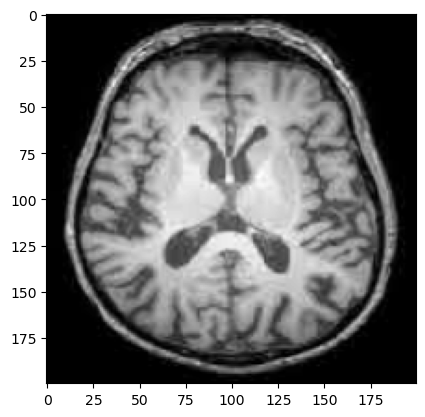

In [25]:
plt.imshow(x[1],cmap='gray')

In [26]:
x_updated=x.reshape(len(x),-1)
x_updated.shape

(253, 40000)

In [27]:
xtrain,xtest,ytrain,ytest=train_test_split(x_updated,y,random_state=10,test_size=.20)
xtrain.shape,xtest.shape

((202, 40000), (51, 40000))

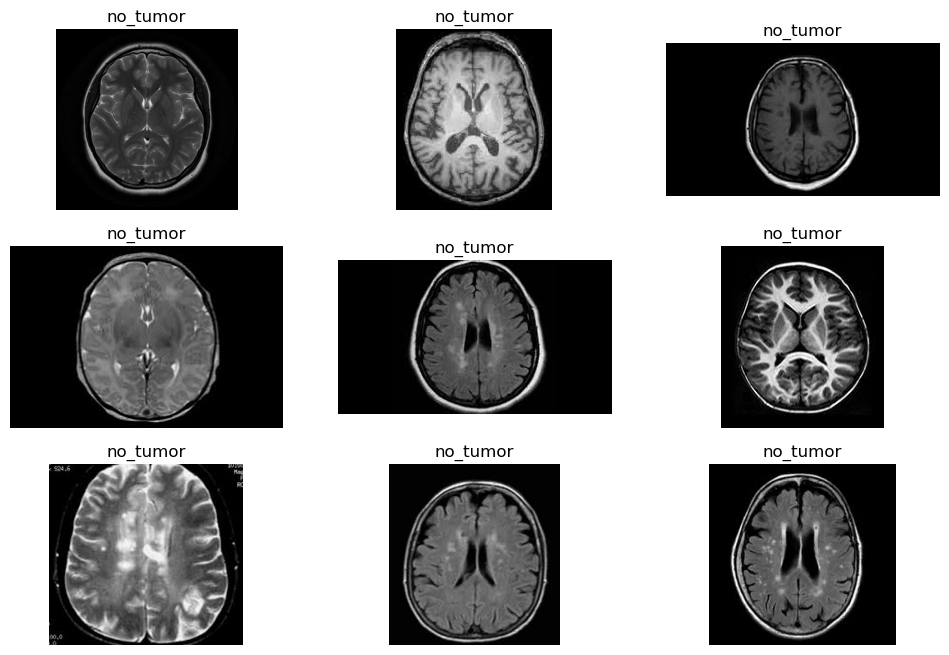

In [33]:
plt.figure(figsize=(12,8))
p= os.listdir('brain_tumor_dataset1/')
c=1
for i in os.listdir('brain_tumor_dataset1/no/')[:9]:
    plt.subplot(3,3,c)
    img=cv2.imread('brain_tumor_dataset1/no/'+i,0)
    img1=cv2.resize(img,(200,200))
    img1=img1.reshape(1,-1)/255

    plt.title("no_tumor")
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    c+=1

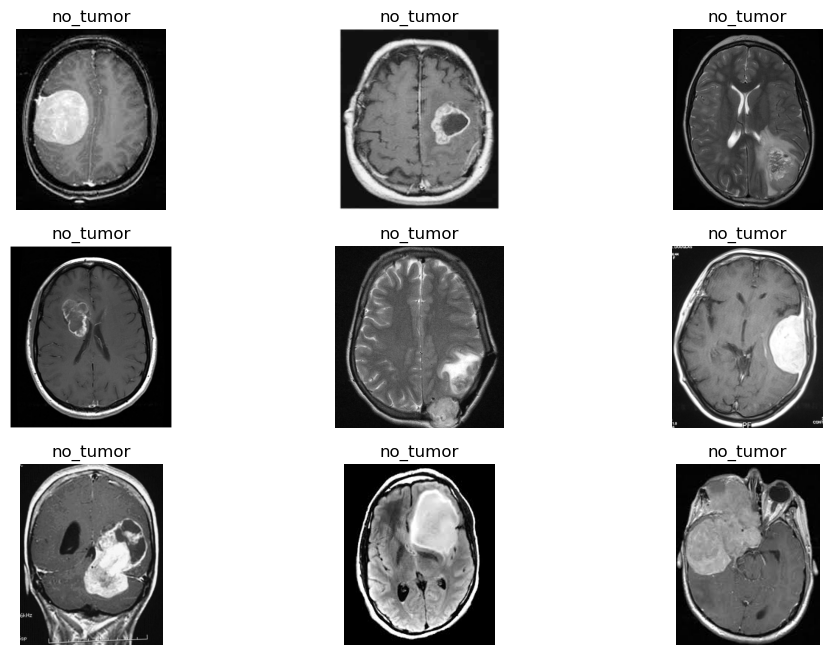

In [34]:
plt.figure(figsize=(12,8))
p= os.listdir('brain_tumor_dataset1/')
c=1
for i in os.listdir('brain_tumor_dataset1/yes/')[:9]:
    plt.subplot(3,3,c)
    img=cv2.imread('brain_tumor_dataset1/yes/'+i,0)
    img1=cv2.resize(img,(200,200))
    img1=img1.reshape(1,-1)/255

    plt.title("no_tumor")
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    c+=1

In [8]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

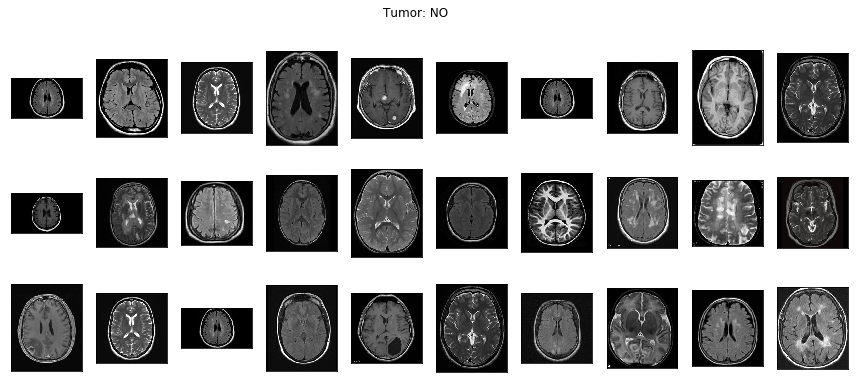

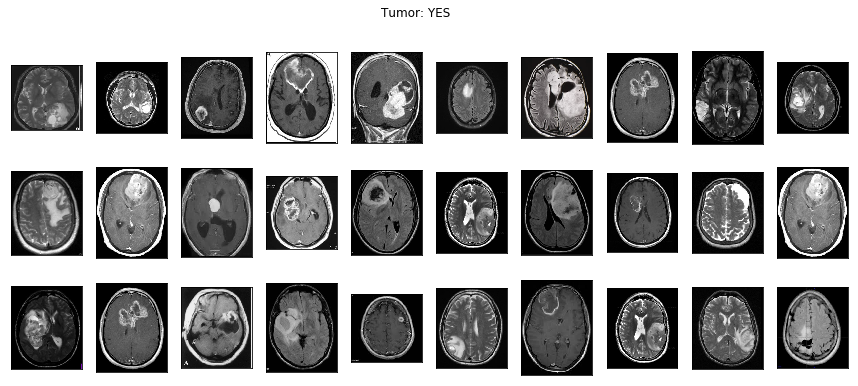

In [9]:
plot_samples(X_train, y_train, labels, 30)

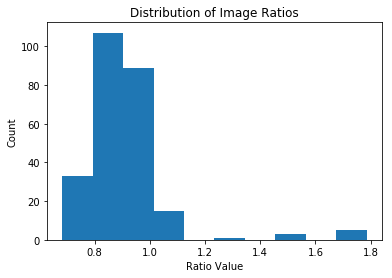

In [10]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

### Cropping the brain out of the images

In [11]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [12]:
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

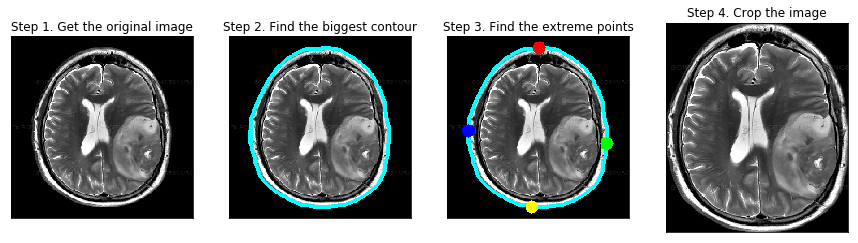

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [14]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

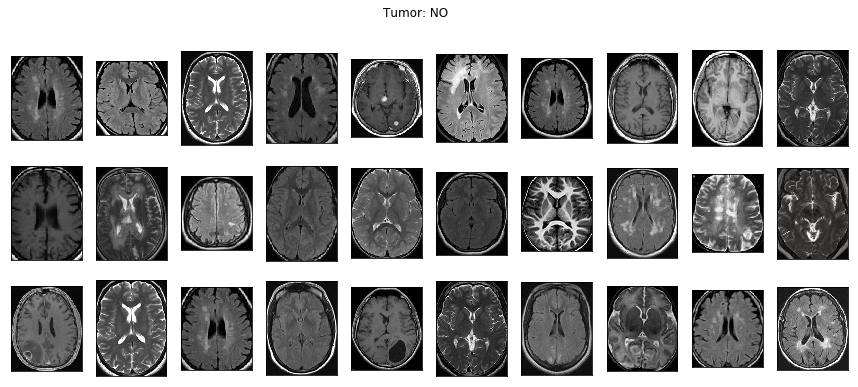

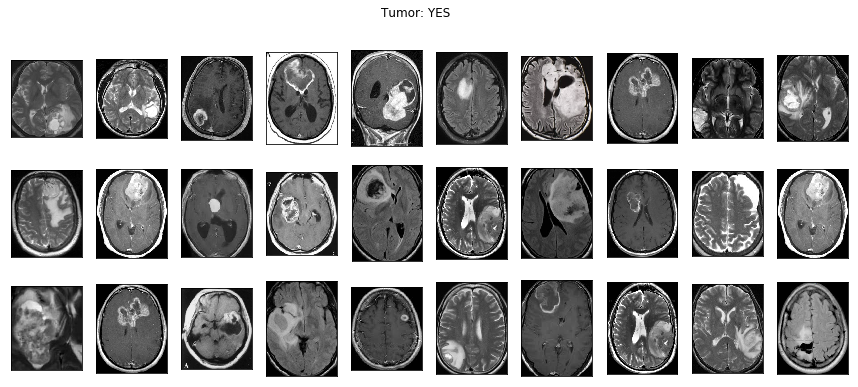

In [15]:
plot_samples(X_train_crop, y_train, labels, 30)

In [16]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [17]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [18]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [19]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

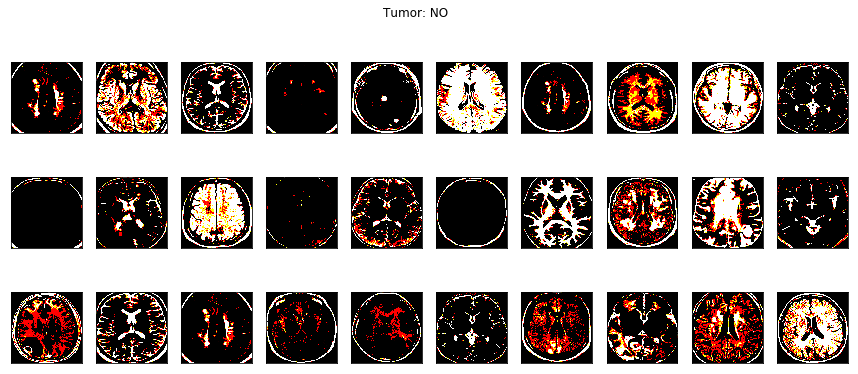

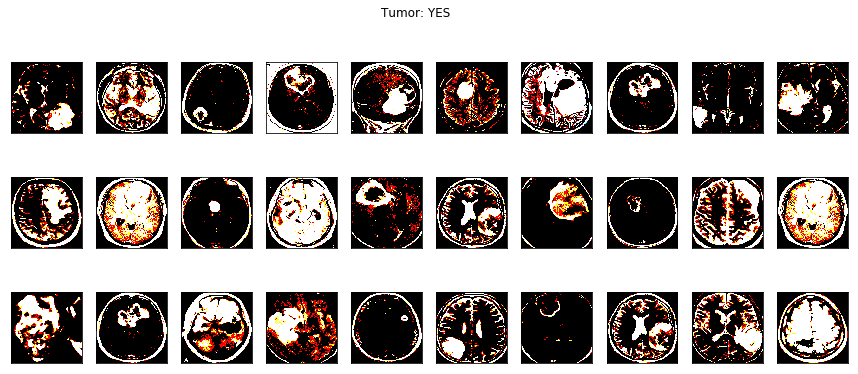

In [20]:
plot_samples(X_train_prep, y_train, labels, 30)

In [35]:
print(xtrain.max(),xtrain.min())
print(xtest.max(),xtest.min())
xtrain=xtrain/255
xtest=xtest/255
print(xtrain.max(),xtrain.min())
print(xtest.max(),xtest.min())#feature scaling

255 0
255 0
1.0 0.0
1.0 0.0


In [38]:
from sklearn.decomposition import PCA

In [39]:
pca =PCA(.98)
#pca_train=pca.fit_transform(xtrain)
#pca_test=pca.fit_transform(xtest)
pca_train=xtrain
pca_test=xtest

## Evaluation metrics

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [42]:
import warnings 
warnings.filterwarnings('ignore')
lg=LogisticRegression(C=0.1)
lg.fit(pca_train,ytrain)

LogisticRegression(C=0.1)

In [43]:
sv=SVC()
sv.fit(pca_train,ytrain)

SVC()

In [44]:
import seaborn as sns
print(lg.score(pca_train,ytrain))
print(lg.score(pca_test,ytest))

1.0
0.6666666666666666


In [45]:
print(sv.score(pca_train,ytrain))
print(sv.score(pca_test,ytest))

0.9207920792079208
0.6470588235294118


## 4. Convolutional Neural Network (CNN) Model Architecture

### 4.1. Data Augmentation



In [21]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [22]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

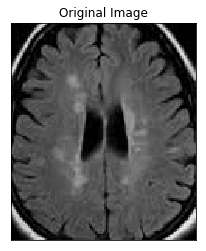

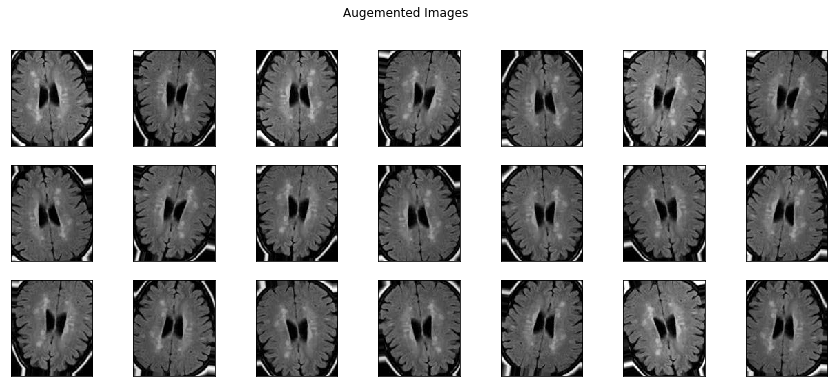

In [23]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [24]:
!rm -rf preview/

In [25]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


### 4.2. Building the CNN Model

In [26]:
# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [27]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [28]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 [==============================] - 27s 538ms/step - loss: 3.9048 - acc: 0.6043 - val_loss: 3.0906 - val_acc: 0.6867
Epoch 2/30
50/50 [==============================] - 25s 497ms/step - loss: 2.8768 - acc: 0.7077 - val_loss: 2.3793 - val_acc: 0.7595
Epoch 3/30
50/50 [==============================] - 25s 490ms/step - loss: 2.3259 - acc: 0.7520 - val_loss: 2.1188 - val_acc: 0.7690
Epoch 4/30
50/50 [==============================] - 24s 484ms/step - loss: 1.5231 - acc: 0.8092 - val_loss: 1.7909 - val_acc: 0.7815
Epoch 5/30
50/50 [==============================] - 24s 487ms/step - loss: 2.2105 - acc: 0.7817 - val_loss: 1.4699 - val_acc: 0.8133
Epoch 6/30
50/50 [==============================] - 24s 480ms/step - loss: 1.5672 - acc: 0.8149 - val_loss: 1.3673 - val_acc: 0.8639
Epoch 7/30
50/50 [==============================] - 25s 502ms/step - loss: 1.2626 - acc: 0.8476 - val_loss: 1.2774 - val_acc: 0.8829
Epoch 8/30
50/50 [==============================] - 24s 470ms/step - 

### 4.3. Model Performance Curves

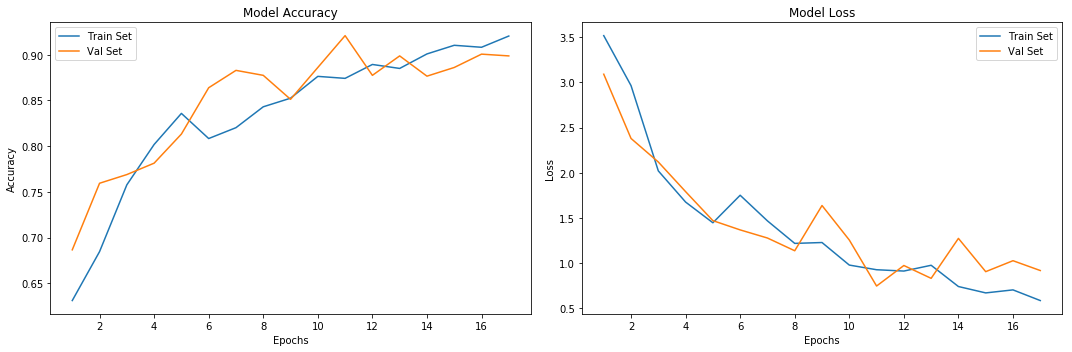

In [29]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### 4.3. Confusion Matrix

Val Accuracy = 0.92


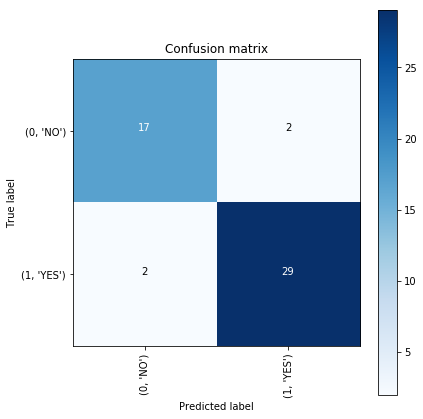

In [30]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.80


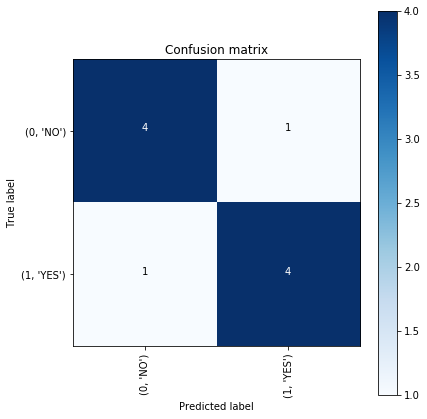

In [31]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

### Images from the `test set` that were misclassified:

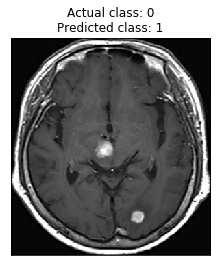

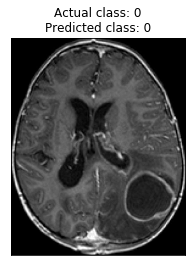

In [32]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()